`jason` is a symbollic language for the JSON family.  Currently, `jason` provides methods for 
converting strings in different formats (eg. Toml, Yaml, Csv, Graphviz) and symbollic operations for:

* jsonpatch
* jsonpointer
* jsonld
* jsondiff
* jsonschema

In [1]:
    import abc, io, IPython, functools
    __all__ = "Jay", "J", "Json", "D", "Alt", "Altair", "Dict", "L", "List", "S", "String", "Csv", "Context", "Schema", "T", "Toml", "Y", "Yaml", "Graphviz", "G"
    if __name__ == '__main__': 
        get_ipython = IPython.get_ipython
    

In [2]:
    class Jay(abc.ABCMeta):
        """Base class for short shortened string formatters."""
        def __mod__(Jay, object, callable=None): 
            object = (callable or Jay.load)(object)
            if not isinstance(object, J):
                if isinstance(object, dict): return D(object)
                if isinstance(object, list): return L(object)        
                if isinstance(object, str): return S(object)
            return object
        format = __call__ = __mod__
        @staticmethod
        def load(object): return object
    class J(metaclass=Jay): ...

In [3]:
    class Echo(J):
        '''echo "{}"'''
        @classmethod
        def load(Bang, str):
            return '\n'.join(IPython.get_ipython().system(Bang.__doc__.splitlines()[0].format(str)))

In [4]:
    class Coffee(Echo): 
        """coffee -pbe "{}"
        
    If coffeescript is installed.
        """
    C = Coffee

In [5]:
    class Json(J): 
        """>>> Json%'{"a": "b"}'
    {'a': 'b'}
    """
        load = staticmethod(__import__('json').loads)     

In [6]:
    class Csv(J): 
        """>>> Csv('''a,b,c
    ... 1,2,3''')
    [['a', 'b', 'c'], ['1', '2', '3']]
    >>> Csv%(' ','''a b c
    ... 1 2 3''')
    [['a', 'b', 'c'], ['1', '2', '3']]
    """
    
        @staticmethod
        def load(object, *, delimiter=','):
            import csv
            if isinstance(object, tuple):
                delimiter, object = object 
            return L(list(csv.reader(io.StringIO(object), delimiter=delimiter)))

In [7]:
    def cfg(str):
        parser = __import__('configparser').ConfigParser()
        parser.read_string(str)
        return {section: dict(parser[section]) for section in parser.sections()}

    class Cfg(J): 
        """>>> Cfg%'[header]\\na: b'
    {'header': {'a': 'b'}}
    """
        load = staticmethod(cfg)

In [8]:
    class Object:
        def __getitem__(O, object):
            if isinstance(object, str) and object.startswith('/'):
                return J(__import__('jsonpointer').resolve_pointer(O, object))        
            return super().__getitem__(object)
                
        def __attr__(O, object, *, attr=None, op='add', in_place=False):
            import jsonpatch
            if not isinstance(object, jsonpatch.JsonPatch):
                if isinstance(object, str):
                    if isinstance(O, str): return S(getattr(super(), F"__{attr}__")(object))
                    object = object.split()
                if isinstance(object, list): object = dict(zip(object, [None]*len(object)))
                object = jsonpatch.apply_patch(O, [
                    {'op': op, 'path': ["/", ""][key.startswith('/')]+key, **({} if op == 'replace' else {'value': value} )}
                    for key, value in (object.items() if isinstance(object, dict) else zip(object, [None]*len(object)))
                ], in_place=in_place)
            return object
        
        
        __add__ = functools.partialmethod(__attr__, attr= 'add', in_place=True)
        __iadd__ = functools.partialmethod(__attr__, attr= 'iadd', in_place=True)
        __sub__ = functools.partialmethod(__attr__, attr= 'sub', op='remove')
        __isub__ = functools.partialmethod(__attr__, attr= 'isub', op='remove', in_place=True)        
        __truediv__ = functools.partialmethod(__attr__, attr= 'floordiv', op='replace')
        __itruediv__ = functools.partialmethod(__attr__, attr= 'ifloordiv', op='replace', in_place=True)
        
        def __or__(O, object): return __import__('jsondiff').diff(O, object)
        
        def __and__(O, object): return O.update({'@context': object}) or O
        
        def __matmul__(O, object): return Context(object) @ O
    
        def __mod__(O, object): return Context(object) % O
                
        def __call__(O, object): return Schema(object)(O)
        
        def __setitem__(O, path, value):
            if path.startswith('/'):
                O += {path: value}
                return O
            return super().__setitem__(path, value)
            
        def __pos__(O): 
            data = dict(O)
            return Context(data.pop('@context')) @ data     
        
        def __neg__(O): 
            data = dict(O)
            return Context(data.pop('@context')) % data
        
    O = Object

In [9]:
    class String(O, str):
        """>>> s = S("foo")
    >>> type(s) # doctest: +ELLIPSIS
    <...S...>

    >>> s["/1"]
    'o'
    
    """
    S = String

In [10]:
    class List(O, list): 
        """>>> l = L(['a', 'foo'])
    >>> type(l) # doctest: +ELLIPSIS
    <...L...>
    >>> l['/0']
    'a'
    >>> l['/1/1']
    'o'
    >>> l + {'/2': 3}
    ['a', 'foo', 3]

    >>> L([1,2]) | [1]
    {delete: [1]}
    >>> L([1,2])-{'/1'}
    [1]
    """
    L = List

In [11]:
    class Dict(O, dict):
        """>>> d = Json%'{"a": [1, {"b": ["foo", 3, "bar"]}]}'
    >>> d
    {'a': [1, {'b': ['foo', 3, 'bar']}]}
    >>> d += {'/c': ['baz', None]}
    >>> d
    {'a': [1, {'b': ['foo', 3, 'bar']}], 'c': ['baz', None]}
    >>> d - {'/a', '/c/1'}
    {'c': ['baz']}
    >>> (d + {'/g': 'testing'}) @ {'g': 'https://foo'}
    [{'https://foo': [{'@value': 'testing'}]}]
    >>> d = (d + {'/g': 'testing'}) & {'g': 'https://foo'}
    >>> +d
    [{'https://foo': [{'@value': 'testing'}]}]
    """
    D = Dict


In [12]:
    class Schema(D):
        """>>> Schema({'type': 'string'})('asdf')
    'asdf'
    
    >>> with __import__('pytest').raises(__import__('jsonschema').ValidationError): 
    ...     Schema({'type': 'string'})(1)
    """
        def __call__(Schema, object):
            __import__('jsonschema').validate(object, Schema)
            return object

In [13]:
    class Context(D):
        """>>> context = Context({"gh": "https://github.com"})
    >>> context@'gh'
    'https://github.com'
    >>> context@{'gh': 'deathbeds'}
    [{'https://github.com': [{'@value': 'deathbeds'}]}]
    """

        def __mod__(Context, object):
            return D(__import__('pyld').jsonld.compact(object, Context))
        
        
        def __matmul__(Context, object):
            if isinstance(object, str):                
                return Context.expand(object, Context)
            object.update({'@context': Context.get('@context', Context)})
            return L(__import__('pyld').jsonld.expand(object))
        
        __call__ = __matmul__

        @staticmethod
        def expand(str, ctx):
            """>>> Context.expand("gh", {"gh": "https://github.com"})
    'https://github.com'
    >>> Context.expand('q', {})
    'q'
    """
            object = __import__('pyld').jsonld.expand({str: '', '@context': ctx})
            if object: return next(iter(object[0]))
            return str

In [14]:
    class Graphviz(J): 
        load = staticmethod(lambda str: __import__('graphviz').Source(str))
            
    G = Graphviz

In [15]:
    class Yaml(J): 
        """>>> Y%'[a, b]'
    ['a', 'b']
    >>> y = Y%'{a: b}'
    >>> y
    {'a': 'b'}
    >>> y += {'c': 1, 'd': 5}
    >>> y
    {'a': 'b', 'c': 1, 'd': 5}
    >>> y - {'c': None}
    {'a': 'b', 'd': 5}
    >>> assert y == {'a': 'b', 'c': 1, 'd': 5}
    >>> y -= {'c': None}
    >>> y
    {'a': 'b', 'd': 5}
    >>> assert not y - "a d"
    """
        @staticmethod
        def load(str): 
            try: import ruamel.yaml as yaml
            except: import yaml

            return yaml.safe_load(io.StringIO(str))
            
    Y = Yaml

In [16]:
    class Toml(J): 
        """>>> T%'title = "TOML Example"'
    {'title': 'TOML Example'}
    """
        @staticmethod
        def load(str): return __import__('toml').loads(str)
    T = Toml

In [19]:
    class Altair(Y):
        """
    >>> c = Alt% '''
    ... data: 
    ...     values: 
    ...     - {a: A, b: 28}
    ...     - {a: B, b: 55}
    ...     - {a: C, b: 43}
    ...     - {a: D, b: 91}
    ...     - {a: E, b: 81}
    ...     - {a: F, b: 53}
    ...     - {a: G, b: 19}
    ...     - {a: H, b: 87}
    ...     - {a: I, b: 52}
    ... mark: bar
    ... encoding: {x: {"field": "a", "type": "ordinal"}, y: {"field": "b", "type": "quantitative"}}'''
    
    """
        
        @staticmethod
        def load(str): return __import__('altair').Chart(**Y%str)
    Alt = Altair

parsing /Users/tonyfast/pidgin/src/jason.py...


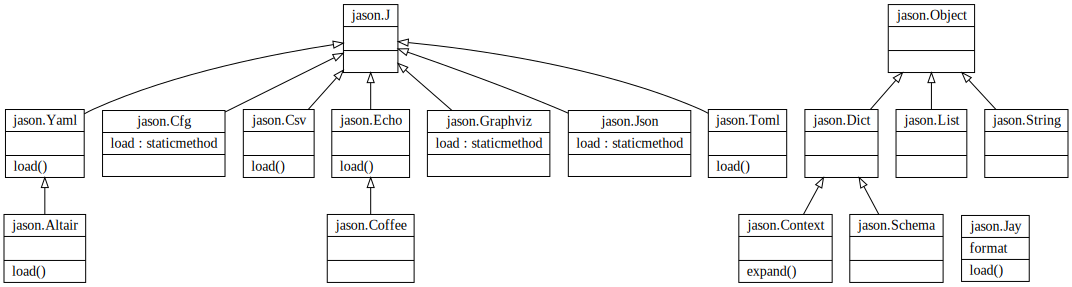

In [20]:
    if __name__ == '__main__':
        import pidgin, nbconvert, black, IPython
        display = IPython.display.display
        with open('jason.py', 'w') as f:
            f.write(black.format_str(nbconvert.PythonExporter(config={
                'TemplateExporter': {'exclude_input_prompt': True}
            }, preprocessors=[pidgin.publishing.TanglePreProcessor()]).from_filename('jason.ipynb')[0], mode=black.FileMode()))
            if 10:
                with IPython.utils.capture.capture_output(stderr=False, stdout=False):
                    !pyreverse --show-builtin  --module-names=y -osvg jason 
            display(IPython.display.SVG('classes.svg'))
            with IPython.utils.capture.capture_output():
                !isort jason.py
        if 10:
            !pyflakes jason.py
        __import__('doctest').testmod()

https://mybinder.org/v2/gh/deathbeds/ypp/a4c56e9a3a761b32cb3c9d5b630f22f4a216dd67?filepath=examples.ipynb